In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

In [5]:
data = pd.read_excel(r'D:\1\Load\DataSet\LoadTexasERCOT.xlsx' )
data.head()


,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2012-01-01 01:00:00.003,7748.160500,878.438488,1289.746813,652.153054,8648.989316,2105.379142,4162.162310,849.000892,26334.030515
1,2012-01-01 01:59:59.997,7559.728089,839.092904,1294.272245,643.483530,8553.212708,2047.755534,4070.416593,845.097363,25853.058967
2,2012-01-01 03:00:00.000,7337.789042,817.995707,1296.491345,631.940923,8461.317967,1961.909818,3946.994332,840.902848,25295.341984
3,2012-01-01 04:00:00.003,7161.895539,814.967883,1297.417294,631.428520,8438.693857,1893.148232,3884.929253,845.452257,24967.932835
4,2012-01-01 04:59:59.997,6984.460743,843.952579,1309.534911,640.892563,8565.433348,1867.358425,3911.610238,862.369386,24985.612193


In [6]:
# Preprocessing
data['Hour_End'] = pd.to_datetime(data['Hour_End'])
data.set_index('Hour_End', inplace=True)



In [7]:
# Use the 'ERCOT' column for forecasting
ercot_values = data['ERCOT']

In [8]:
# Split data into training (2012-2014) and testing (2015)
train_data = ercot_values['2012':'2014']
test_data = ercot_values['2015']

In [9]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [10]:
# Create sequences for GRU input
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [11]:
seq_length = 24  # Use past 24 hours to predict the next value
x_train, y_train = create_sequences(train_scaled, seq_length)
x_test, y_test = create_sequences(test_scaled, seq_length)

In [12]:
# Build the GRU model
model = Sequential([
    GRU(50, activation='relu', input_shape=(seq_length, 1), return_sequences=False),
    Dense(1)
])

d:\1\alpha\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam', loss='mse')

In [14]:
model.fit(x_train, y_train, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 88s 30ms/step - loss: 0.0095
Epoch 2/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 75s 28ms/step - loss: 4.2943e-04
Epoch 3/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 75s 29ms/step - loss: 3.3307e-04
Epoch 4/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 90s 31ms/step - loss: 3.0775e-04
Epoch 5/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 68s 26ms/step - loss: 2.8480e-04
Epoch 6/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 73s 28ms/step - loss: 2.7439e-04
Epoch 7/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 102s 36ms/step - loss: 2.5032e-04
Epoch 8/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 131s 31ms/step - loss: 2.1969e-04
Epoch 9/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 146s 33ms/step - loss: 2.0486e-04
Epoch 10/10
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 145s 34ms/step - loss: 1.9087e-04


In [15]:
# Make predictions
predictions_scaled = model.predict(x_test)
predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test)

273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [16]:
# Evaluate the model
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

In [17]:
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 406.33610273694836
RMSE: 559.1467542006753
MAPE: 1.042421476485784%


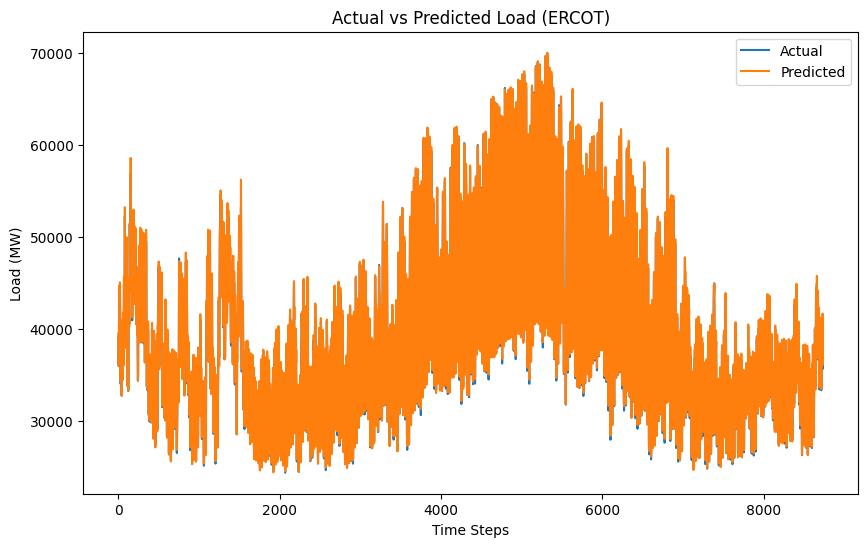

In [ ]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Load (ERCOT)')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.show()